# **Path**

In [ ]:
trainPath = '/content/drive/MyDrive/DataColab/BrainTumrMRIDataset/BrainTumorMRIDataset/Training'
testPath = '/content/drive/MyDrive/DataColab/BrainTumrMRIDataset/BrainTumorMRIDataset/Testing'

# **Constant**

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
SEED = 42
EPOCHS = 20
MODEL_INPUT = (IMAGE_SIZE , IMAGE_SIZE , 3)

# **Image Path in data frame**

In [ ]:
import os
import pandas as pd

def load_paths_to_df(main_dir):
    image_paths = []
    labels = []


    for label in os.listdir(main_dir):
        label_path = os.path.join(main_dir, label)


        if not os.path.isdir(label_path):
            continue

        # iterate through images in that folder
        for img in os.listdir(label_path):
            img_path = os.path.join(label_path, img)
            image_paths.append(img_path)
            labels.append(label)

    # create DataFrame
    df = pd.DataFrame({
        "image_path": image_paths,
        "label": labels
    })

    return df

In [ ]:
train_df = load_paths_to_df(trainPath)
test_df = load_paths_to_df(testPath)

In [ ]:
train_df.shape

(5712, 2)

# **Data Visualization**

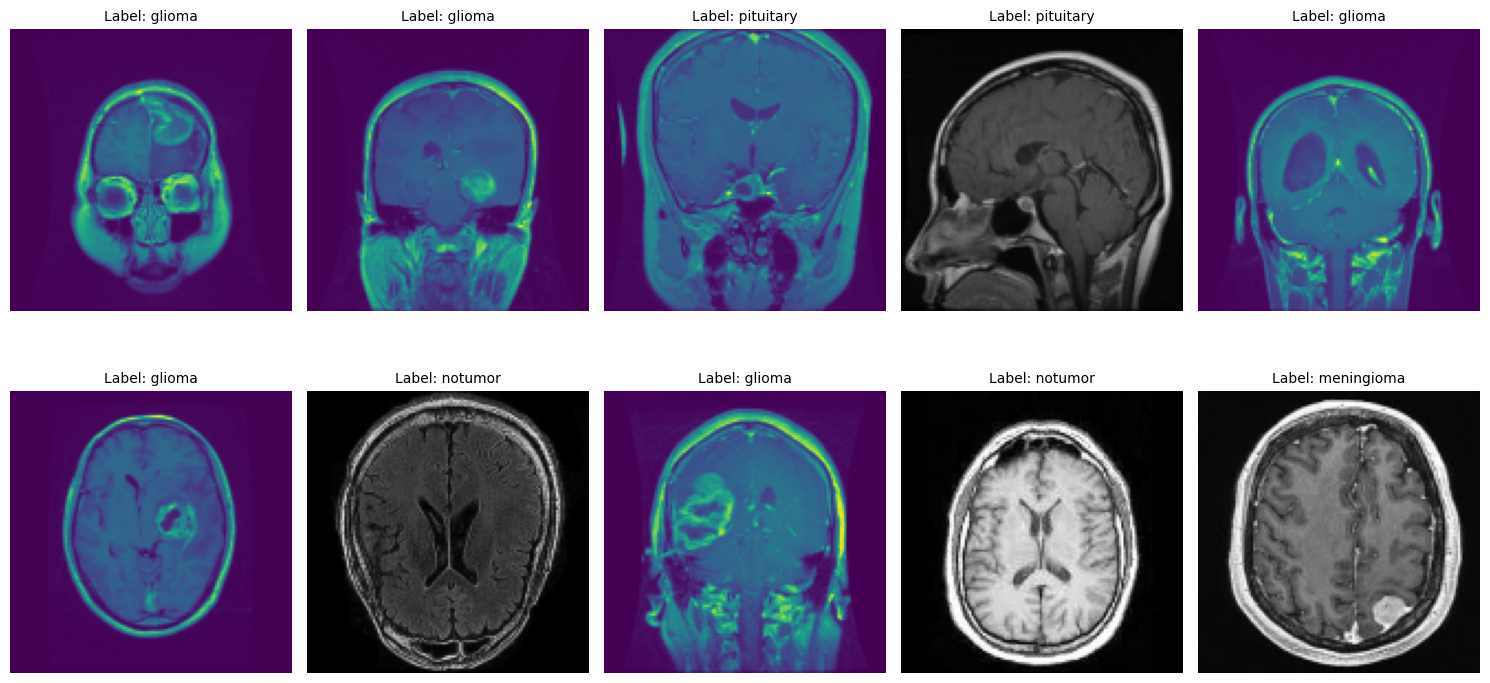

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage.transform import resize


random_indices = random.sample(range(len(train_df)), 10)


fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):

    img = plt.imread(train_df.iloc[idx].image_path)
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), anti_aliasing=True)

    axes[i].imshow(img)
    axes[i].axis('off')

    axes[i].set_title(f"Label: {train_df.iloc[idx].label}", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
img = plt.imread(train_df.iloc[0].image_path)

In [ ]:
train_df.iloc[0].label

'glioma'

# **ImageDataGenerator**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
setTrainGen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

setTestGen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
trainGen = setTrainGen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size = (IMAGE_SIZE , IMAGE_SIZE) ,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    subset="training",
    shuffle=False,
    seed = SEED
)

testGen = setTestGen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle=False,
    seed = SEED
)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
trainGen.class_indices # important for deploy

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
testGen.class_indices # important for deploy

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
x_train , y_train = next(trainGen)
x_test , y_test = next(testGen)

In [ ]:
x_train.shape # important for model

(32, 128, 128, 3)

Text(0.5, 1.0, 'Label : 0 ')

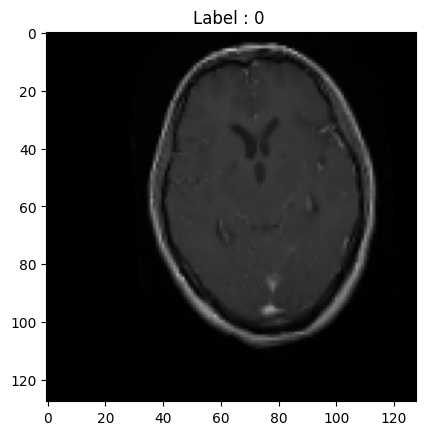

In [ ]:
import numpy as np

plt.imshow(x_train[0])
plt.title(f'Label : {np.argmax(y_train[0])} ' ) #np.argmax(one_hot, axis=1) to convert oneHot to number

Text(0.5, 1.0, 'Label : 1 ')

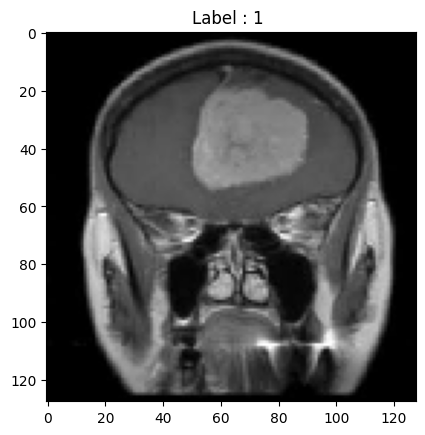

In [ ]:
import numpy as np

plt.imshow(x_test[0])
plt.title(f'Label : {np.argmax(y_test[0])} ' )



```
Image generator output in image with shape = (128 , 128 , 3)
```



# **Model**

In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense , GlobalAveragePooling2D , Flatten , Dropout
from keras.applications import VGG16

In [ ]:
model = Sequential()

In [ ]:
VGG = VGG16(include_top = False ,
            weights = "imagenet" ,
            input_shape= (IMAGE_SIZE , IMAGE_SIZE ,3) )

VGG.trainable = False # freeze all layers
# we will make fine tunning on feature ...

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in VGG.layers[-10:]:
    layer.trainable = True

In [ ]:
# Build the final model

model = Sequential()
model.add(VGG)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense( len(train_df['label'].unique()) , activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 14,618,500 (55.77 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [ ]:
len(train_df['label'].unique())

4

In [ ]:
from tensorflow.keras.optimizers import Adam

# label is oneHot
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# model.fit ( trainGen , batch_size = BATCH_SIZE ,
#             epochs = EPOCHS ,
#             steps_per_epoch=len(trainGen) ,
#             verbose=1 )

In [ ]:
print(''' Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.6883 - loss: 0.7396
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.9014 - loss: 0.2735
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms/step - accuracy: 0.9332 - loss: 0.1896
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - accuracy: 0.9433 - loss: 0.1621
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.9610 - loss: 0.1065
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - accuracy: 0.9680 - loss: 0.0849
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 278ms/step - accuracy: 0.9698 - loss: 0.0878
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.9790 - loss: 0.0625
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 282ms/step - accuracy: 0.9756 - loss: 0.0823
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.9766 - loss: 0.0705
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 0.9845 - loss: 0.0414
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.9868 - loss: 0.0459
Epoch 13/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.9824 - loss: 0.0514
Epoch 14/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 275ms/step - accuracy: 0.9910 - loss: 0.0342
Epoch 15/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.9905 - loss: 0.0302
Epoch 16/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.9903 - loss: 0.0351
Epoch 17/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.9896 - loss: 0.0394
Epoch 18/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 273ms/step - accuracy: 0.9929 - loss: 0.0213
Epoch 19/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.9924 - loss: 0.0300
Epoch 20/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - accuracy: 0.9924 - loss: 0.0250
<keras.src.callbacks.history.History at 0x7e674bf0acf0> ''')

 Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.6883 - loss: 0.7396
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.9014 - loss: 0.2735
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms/step - accuracy: 0.9332 - loss: 0.1896
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - accuracy: 0.9433 - loss: 0.1621
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.9610 - loss: 0.1065
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - accuracy: 0.9680 - loss: 0.0849
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 278ms/step - accuracy: 0.9698 - loss: 0.0878
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.9790 - loss: 0.0625
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 282ms/step - accuracy: 0.9756 - loss: 0.0823
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.9766 - loss: 0.0705
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 0.9845 - loss: 0.0414
Epoch 12/20
179/179 

# **Save & Load Model**

In [ ]:
model.export("model_Ai_dir")

Saved artifact at 'model_Ai_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134381158223312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158223888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158224656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158223696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158223504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158225232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158225808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158226576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158227344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158226192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134381158224848: 

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('model_Ai_dir', 'zip', 'model_Ai_dir')
files.download('model_Ai_dir.zip') # For Download Local

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Evaluation**

 ## **Loss & Accuracy**

In [ ]:
loss , acc = model.evaluate(testGen)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 381s 9s/step - accuracy: 0.9837 - loss: 0.0451
loss : 0.026897279545664787
accuracy : 99.08466935157776


In [ ]:
print(f'loss : {loss}')
print(f'accuracy : {acc*100}')

## **Classification Report**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np
from tensorflow.keras.models import load_model


testGen.reset()

y_prob = model.predict(testGen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = testGen.classes

# Class names (in correct index order)
class_indices = testGen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

41/41 ━━━━━━━━━━━━━━━━━━━━ 339s 8s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       300
  meningioma       0.99      0.97      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
print('''Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       300
  meningioma       0.99      0.97      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311''')

## **Confusion Matrix**

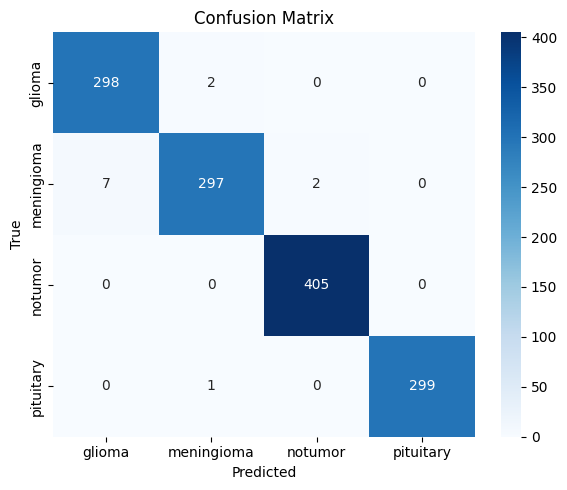

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## **ROC & AUC**

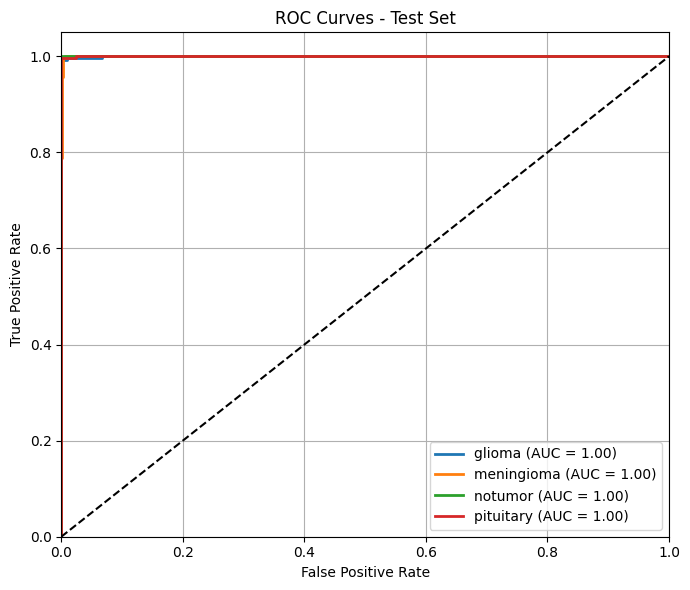

In [ ]:
n_classes = len(target_names)


y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(7, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], linewidth=2, label=f"{target_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# **Deploy** <a id="deploy"></a>

In [ ]:
# (1) image read
# (2) shape to (1 , 128 , 128 , 3)
# (3) to model
# (4) output = [one Hot]
# (5) argmax(output)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_to_deploy(imagePath , model) :

  img = load_img(imagePath, target_size=(128, 128))
  img_array = img_to_array(img)
  img_array = img_array / 255.0             # same scaling used in training
  img_array = np.expand_dims(img_array, axis=0)

  pred = model.predict(img_array)
  pred = np.argmax(pred)

  class_dict = {0 : 'glioma' , 1 :'meningioma' , 2 :'notumor' , 3 :'pituitary' }
  pred = class_dict[pred]

  return pred

In [ ]:
pred = predict_to_deploy(train_df.iloc[0].image_path , model)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


'glioma'

In [ ]:
pred

'glioma'

In [ ]:
import tensorflow as tf
tf.__version__

'2.19.0'